# Gene Expression Classification

## Data Preparation

In [1]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import xgboost as xgb
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [2]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('/content/actual.csv')
print(y.shape)
y.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [3]:
y['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

In [4]:
# Recode label to numeric
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting convenience later on

In [5]:
# Import training data
df_train = pd.read_csv('/content/data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('/content/data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [6]:
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [7]:
df_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [8]:
# Transform all the call values to numbers (not used in this version)
# df_train.replace(['A','P','M'],['1','2','3'], inplace=True)
# df_test.replace(['A','P','M'],['1','2','3'], inplace=True)

# Remove "call" columns from training and testing data
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

In [9]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

In [10]:
test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

In [11]:
X_train = X_train_tr.T
X_test = X_test_tr.T

print(X_train.shape)
X_train.head()

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


In [12]:
# Clean up the column names for training and testing data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for Testing data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [13]:
X_train.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [14]:
# Split into train and test (we first need to reset the index as the indexes of two dataframes need to be the same before you combine them).

# Subset the first 38 patient's cancer types
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

In [15]:
X_test.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
1,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
2,-62,-23,-7,142,-233,-284,-167,-97,-12,-70,...,129,383,46,104,15,245,164,84,100,-18
3,22,-153,17,276,-211,-250,55,-141,0,500,...,413,399,16,558,24,893,297,6,1971,-42
4,86,-36,-141,252,-201,-384,-420,-197,-60,-468,...,341,91,-84,615,-52,1235,9,7,1545,-81


In [16]:
X_train.describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,...,178.763158,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,...,84.826830,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,...,30.000000,224.000000,-178.000000,36.000000,-112.000000,195.000000,41.000000,-50.000000,-2.000000,-94.000000
25%,-138.750000,-205.000000,-83.250000,81.250000,-374.250000,-547.000000,-169.000000,-239.250000,36.000000,-47.000000,...,120.000000,575.500000,-42.750000,174.500000,-48.000000,595.250000,232.750000,8.000000,136.000000,-42.750000
50%,-106.500000,-141.500000,-43.500000,200.000000,-263.000000,-426.500000,-33.500000,-185.500000,99.500000,70.500000,...,174.500000,700.000000,10.500000,266.000000,-18.000000,744.500000,308.500000,20.000000,243.500000,-26.000000
75%,-68.250000,-94.750000,47.250000,279.250000,-188.750000,-344.750000,79.000000,-144.750000,152.250000,242.750000,...,231.750000,969.500000,57.000000,451.750000,9.250000,1112.000000,389.500000,30.250000,487.250000,-11.500000
max,17.000000,-20.000000,265.000000,392.000000,-51.000000,-155.000000,419.000000,-24.000000,283.000000,561.000000,...,356.000000,1653.000000,218.000000,2527.000000,52.000000,2315.000000,1109.000000,115.000000,3193.000000,36.000000


In [19]:
matriz_correlacao = X_train.corr()

In [20]:
matriz_correlacao_v1 =  matriz_correlacao[matriz_correlacao>0.99]
matriz_correlacao_v1

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFFX-BioB-M_at,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFFX-BioB-3_at,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFFX-BioC-5_at,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFFX-BioC-3_at,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X83863_at,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Z17240_at,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
L49218_f_at,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [21]:
matriz_correlacao_v2 = matriz_correlacao_v1.sum()
variaveis_correlacionadas = matriz_correlacao_v2[matriz_correlacao_v2>1]
variaveis_correlacionadas

Gene Accession Number
X07203_at      1.992730
M69203_s_at    1.994882
J04130_s_at    1.994882
M27394_s_at    1.992730
X04602_s_at    1.994788
Y00081_s_at    1.994788
J03801_f_at    1.991816
M19045_f_at    1.991816
dtype: float64

In [22]:
X_train = X_train.drop(columns=['M27394_s_at','X07203_at','X04602_s_at','J03801_f_at'])
 # Retirar os exames que estão muito correlacionados

In [23]:
X_test = X_test.drop(columns=['M27394_s_at','X07203_at','X04602_s_at','J03801_f_at'])

In [24]:
# Convert from integer to float
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform
X_train_scl = pd.DataFrame(X_train_scl)

In [25]:
pca = PCA()
pca.fit_transform(X_train_scl)

array([[ 1.85745006e+01,  5.79370913e+00, -1.94280093e+01, ...,
        -3.21990995e+00, -5.16753081e-01,  1.45136254e-14],
       [-7.35011373e+00,  1.00239202e+01,  1.17838446e+01, ...,
         3.81991469e+00, -2.25356644e-01,  1.45136254e-14],
       [ 5.28739170e+01,  1.13311644e+01, -2.95702850e+01, ...,
        -3.13910483e+00,  3.61324819e+00,  1.45136254e-14],
       ...,
       [ 2.54971947e+01, -1.40696663e+01,  4.88705044e+01, ...,
        -1.60415516e+00,  2.28639998e+00,  1.45136254e-14],
       [ 1.73674429e+01, -2.47662228e+01,  4.42268202e+01, ...,
         2.44902549e+00, -1.37469168e+00,  1.45136254e-14],
       [ 1.64515200e+01, -1.57999355e+01,  2.76704813e+01, ...,
        -6.92676644e-01,  5.32933175e+00,  1.45136254e-14]])

28 features explain around 98% of the variance. From 7129 features to 28, not too bad.


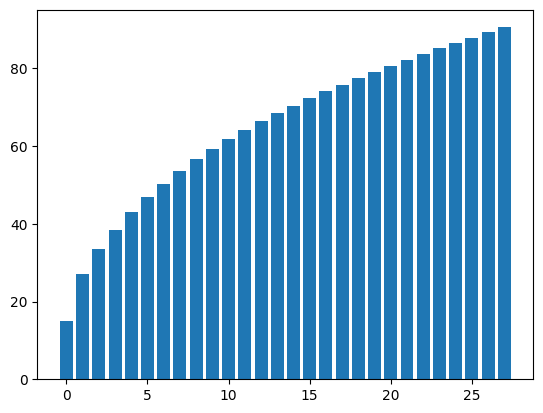

In [26]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1

print(k, " features explain around 98% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train_scl)
X_train_pca = pca.transform(X_train_scl)
X_test_pca = pca.transform(X_test_scl)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

In [27]:
pca3 = PCA(n_components=3).fit(X_train_scl)
pca3 = PCA(n_components=3).fit(X_test_scl)
X_train_reduced = pca3.transform(X_train_scl)
X_test_reduced = pca3.transform(X_test_scl)
print(X_train_reduced)

[[-20.17976826  28.72595203  -8.1506945 ]
 [-19.16558129   5.12134758  -5.64155161]
 [-20.43117741  52.00484695  -9.56131001]
 [-20.87965437  20.32785247 -12.32526198]
 [-19.07836896 -12.90767058   0.43110163]
 [-16.92662463   1.18016564  -5.87906871]
 [-18.49238695  27.72592367  -8.09980379]
 [-21.16422327  48.56342341 -11.78774244]
 [-17.95067869  22.29227686  -7.75950108]
 [-17.5674614   -5.65053608  -4.39911836]
 [-18.33297977  -4.42750225  -5.38045557]
 [-16.31808918 -25.30021811  -1.68165783]
 [-16.74667106  -8.20781128  -8.46118769]
 [-20.67911408   8.46824956   0.78887934]
 [-17.81778268 -13.25608116  -4.32273968]
 [-18.29591173   4.17622467  -5.65226137]
 [-21.47460101  55.96162428 -13.02347589]
 [-16.87780838 -10.06109194   1.98760068]
 [-16.53965564 -16.65176265  -4.97728826]
 [-21.0219698   19.58802875 -14.42359535]
 [-18.52684297 -24.14712835  -2.79994238]
 [-18.26533733  -3.98986965  -6.35136242]
 [-19.20750333   3.11090534  -4.02825792]
 [-19.55028876  13.37695925  -5.96

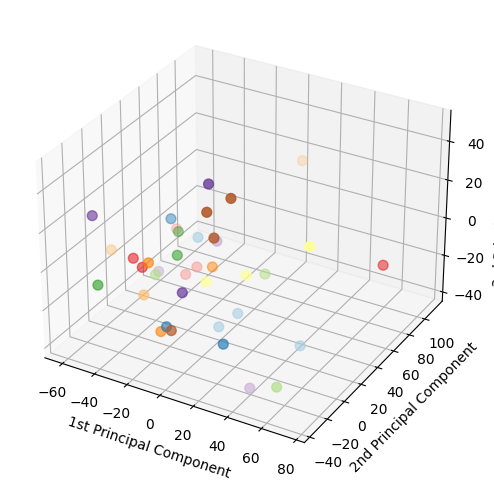

In [28]:
# Criando o gráfico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotando os dados no gráfico 3D
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train.iloc[:, 0], cmap=plt.cm.Paired, s=50)

# Configurando os rótulos dos eixos
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')

# Exibindo o gráfico
plt.show()


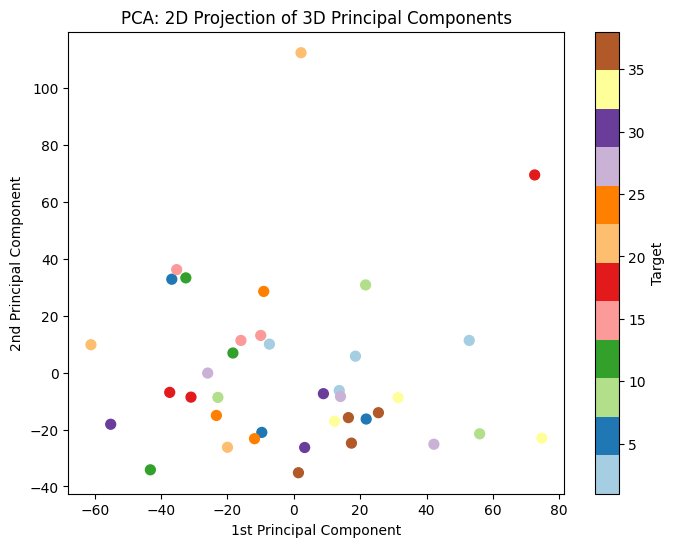

In [30]:
# Criando um gráfico 2D com os dois primeiros componentes principais
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.iloc[:, 0], cmap=plt.cm.Paired, s=50)
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('PCA: 2D Projection of 3D Principal Components')
plt.colorbar(label='Target')
plt.show()


## Model Building

### Baseline

Let's start by establishing a naive baseline. This doesn't require a model, we are just taking the proportion of tests that belong to the majority class as a baseline. In other words, let's see what happens if we were to predict that every patient belongs to the "ALL" class.

In [31]:
print("Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of ", round(1 - np.mean(y_test.iloc[:,1]), 3), ".", sep = '')

Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of 0.588.


### K-Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-means accuracy: 0.765


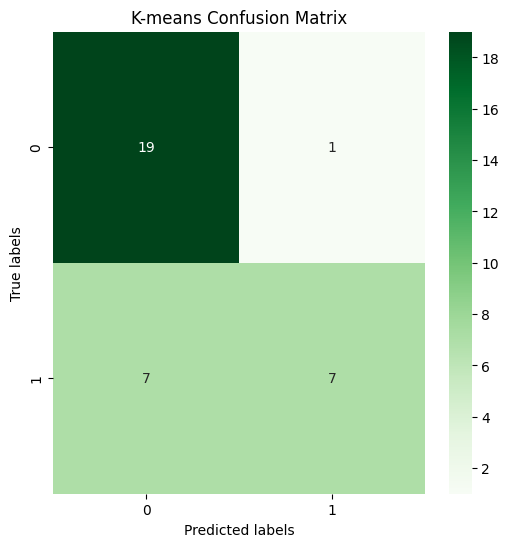

In [32]:

# Treine o modelo K-means
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_train_scl)

# Faça previsões
km_pred = kmeans.predict(X_test_scl)

# Calcule a acurácia
accuracy = accuracy_score(y_test.iloc[:, 1], km_pred)
print('K-means accuracy:', round(accuracy, 3))

# Crie a matriz de confusão
cm_km = confusion_matrix(y_test.iloc[:, 1], km_pred)

# Plote a matriz de confusão usando seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm_km, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('K-means Confusion Matrix')
plt.show()


### Naive Bayes

Naive Bayes accuracy: 0.912


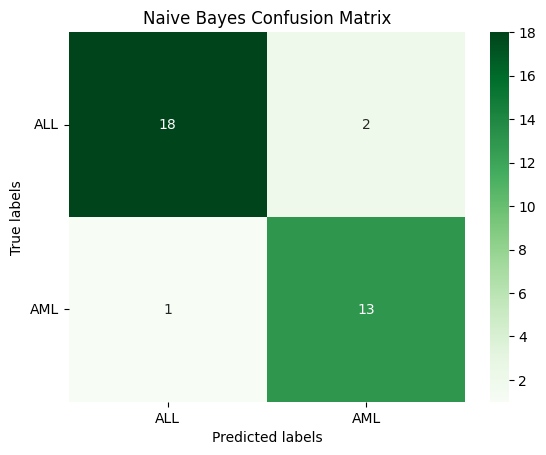

In [33]:
# Create a Gaussian classifier
nb_model = GaussianNB()

nb_model.fit(X_train_scl, y_train.iloc[:,1])

nb_pred = nb_model.predict(X_test_scl)

print('Naive Bayes accuracy:', round(accuracy_score(y_test.iloc[:,1], nb_pred), 3))

cm_nb =  confusion_matrix(y_test.iloc[:,1], nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Naive Bayes Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Logistic Regression

####With PCA Whithout Grid

Logistic Regression accuracy: 0.882


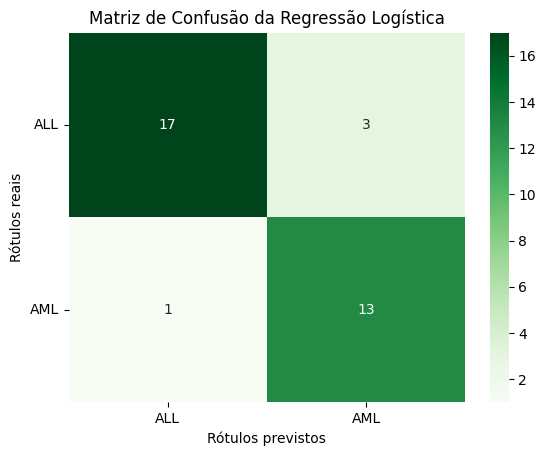

In [34]:
# Inicialize o modelo de Regressão Logística com os parâmetros escolhidos
logistic_model = LogisticRegression()

# Treine o modelo usando os dados de treinamento
logistic_model.fit(X_train_reduced, y_train.iloc[:, 1])

# Faça previsões usando o modelo treinado nos dados de teste
logistic_predictions = logistic_model.predict(X_test_reduced)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test.iloc[:, 1], logistic_predictions)
print('Logistic Regression accuracy:', round(accuracy, 3))

# Crie e exiba a matriz de confusão
cm_logistic = confusion_matrix(y_test.iloc[:, 1], logistic_predictions)
ax = plt.subplot()
sns.heatmap(cm_logistic, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, título e ticks
ax.set_xlabel('Rótulos previstos')
ax.set_ylabel('Rótulos reais')
ax.set_title('Matriz de Confusão da Regressão Logística')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)

# Exiba o gráfico
plt.show()


####Without Grid Search

Logistic Regression accuracy: 0.824


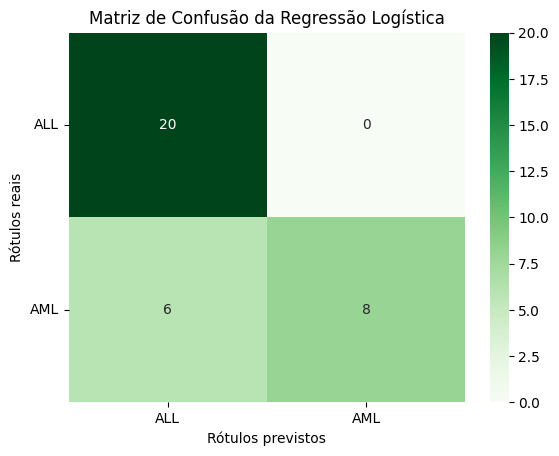

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Inicialize o modelo de Regressão Logística com os parâmetros escolhidos
logistic_model = LogisticRegression()

# Treine o modelo usando os dados de treinamento
logistic_model.fit(X_train_scl, y_train.iloc[:, 1])

# Faça previsões usando o modelo treinado nos dados de teste
logistic_predictions = logistic_model.predict(X_test_scl)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test.iloc[:, 1], logistic_predictions)
print('Logistic Regression accuracy:', round(accuracy, 3))

# Crie e exiba a matriz de confusão
cm_logistic = confusion_matrix(y_test.iloc[:, 1], logistic_predictions)
ax = plt.subplot()
sns.heatmap(cm_logistic, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, título e ticks
ax.set_xlabel('Rótulos previstos')
ax.set_ylabel('Rótulos reais')
ax.set_title('Matriz de Confusão da Regressão Logística')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)

# Exiba o gráfico
plt.show()


#### With PCA and Grid Search

Best Parameters:
 {'C': 0.01, 'penalty': 'l2'}
Logistic Regression accuracy: 0.765


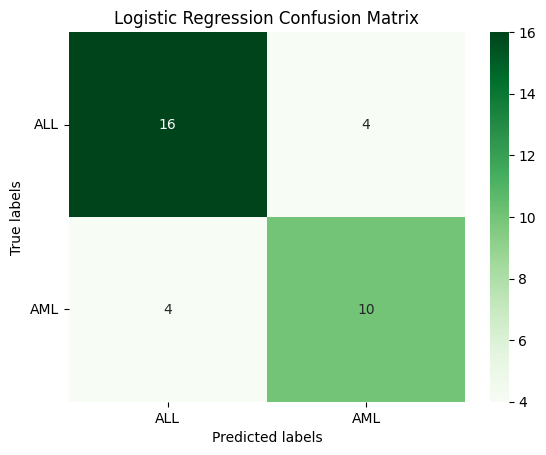

In [36]:
#Use o GridSearch para otimizar o modelo
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10],
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator,
                  param_grid=log_grid,
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train_reduced, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test_reduced)
print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

####With Grid Search

Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Logistic Regression accuracy: 0.941


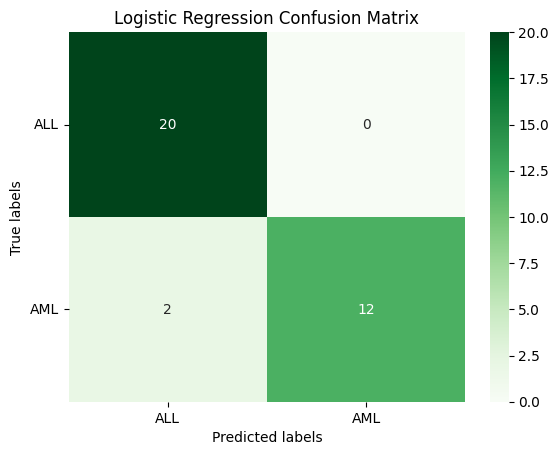

In [37]:
#Usando GridSearch para otimizar o modelo
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10],
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator,
                  param_grid=log_grid,
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train_scl, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log1 = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test_scl)
print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Support Vector Machine


Best Parameters:
 {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.882


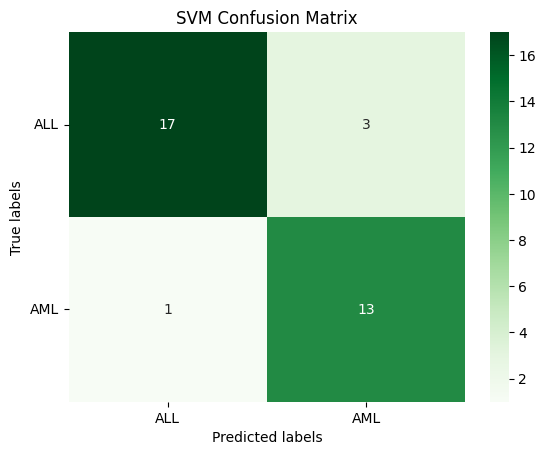

In [38]:
# Parameter grid
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 1.5, 2], "kernel": ["linear", "rbf", "poly"], "decision_function_shape" : ["ovo", "ovr"]}

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_reduced, y_train.iloc[:,1])

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test_reduced)

print('SVM accuracy:', round(accuracy_score(y_test.iloc[:,1], svm_pred), 3))

cm_svm =  confusion_matrix(y_test.iloc[:,1], svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens')

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('SVM Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Random Forest

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 50}
Random Forest accuracy: 0.912


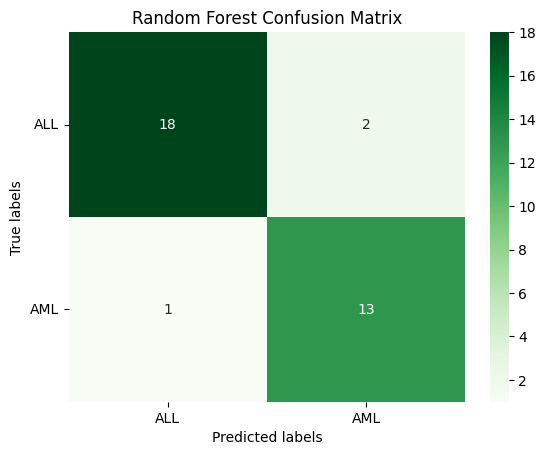

In [39]:
# Hyperparameters search grid
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [50 , 40, 60],
         'max_features': [0.6, 0.5, 0.4],
         'min_samples_leaf': [5, 6, 7],
         'min_samples_split': [3, 5, 7]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fine-tune the hyperparameters
rf_model.fit(X_train_scl, y_train.iloc[:,1])

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test_scl)

print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred), 3))

cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forest Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

In [40]:
classificador_forest = RandomForestClassifier(n_estimators=50, criterion='gini', min_samples_split=3, min_samples_leaf=5, max_features=0.6, bootstrap=False, random_state=0)
classificador_forest.fit(X_train_scl , y_train)

RandomForestClassifier(bootstrap=False, max_features=0.6, min_samples_leaf=5,
                       min_samples_split=3, n_estimators=50, random_state=0)

### XG Boost

XGB (no Grid Search) accuracy: 0.912


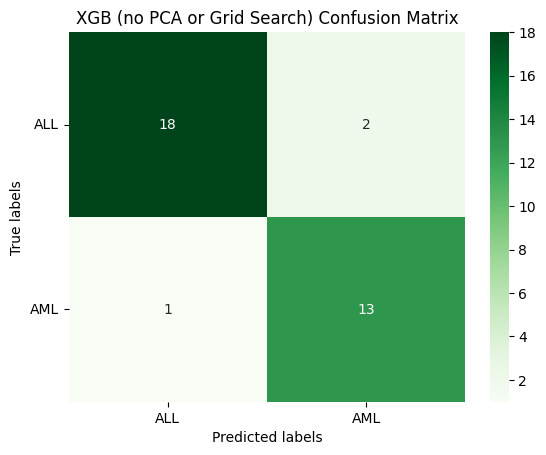

In [43]:
xgb3_model = xgb.XGBClassifier()
xgb3_model.fit(X_train_scl, y_train.iloc[:,1])

xgb3_pred = xgb3_model.predict(X_test_scl)

print('XGB (no Grid Search) accuracy:', round(accuracy_score(y_test.iloc[:,1], xgb3_pred), 3))

cm_xgb3 = confusion_matrix(y_test.iloc[:,1], xgb3_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb3, annot=True, ax = ax, fmt='g', cmap='Greens')

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('XGB (no PCA or Grid Search) Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Neural Network

In [44]:
!pip install scikeras

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define a random seed
seed = 42

# Initialize the Keras model
def create_model():
    model = Sequential()
    model.add(Dense(6, input_dim=X_train_scl.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create training/validation sets
partial_X_train = X_train_scl[:30]
X_val = X_train_scl[30:]

y_train_label = y_train.iloc[:,1]
partial_y_train = y_train_label[:30]
y_val = y_train_label[30:]



In [45]:

# Crie uma função para encapsular o pré-processamento e treinamento do modelo
def create_pipeline():
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0, validation_split=0.2)))
    pipeline = Pipeline(estimators)
    return pipeline

# Defina os parâmetros que você deseja otimizar
param_grid = {
    'mlp__epochs': [50, 100, 150],
    'mlp__batch_size': [10, 20, 30]
}

# Crie o modelo de Grid Search com o pipeline e os parâmetros
grid = GridSearchCV(estimator=create_pipeline(), param_grid=param_grid, cv=10)

# Treine o modelo usando os dados de treino
grid_result = grid.fit(partial_X_train, partial_y_train)

# Obtenha os melhores resultados e o modelo otimizado
best_params = grid_result.best_params_
best_accuracy = grid_result.best_score_
optimized_model = grid_result.best_estimator_

def evaluate_neural_network(pipeline, X_test, y_test):
    # Predict using the pipeline
    nn_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, nn_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, nn_pred)

    return accuracy, cm

# Avalie o modelo otimizado usando os dados de validação
accuracy, cm = evaluate_neural_network(optimized_model, X_val, y_val)


print('Melhores Parâmetros:', best_params)
print('Melhor Acurácia durante a validação cruzada:', best_accuracy)
print('Acurácia no conjunto de validação:', accuracy)



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` wi

Melhores Parâmetros: {'mlp__batch_size': 30, 'mlp__epochs': 50}
Melhor Acurácia durante a validação cruzada: 0.9333333333333332
Acurácia no conjunto de validação: 0.875


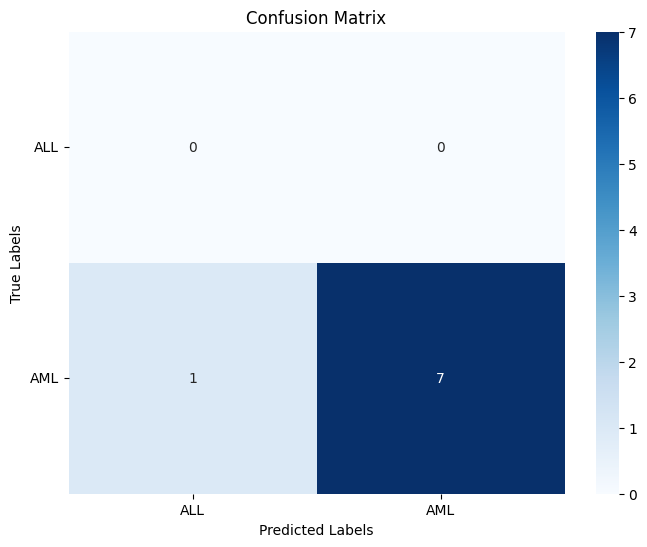

In [46]:
# Crie um heatmap da matriz de confusão com rótulos personalizados
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Defina rótulos e título
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Personalize os rótulos dos eixos
ax.set_xticklabels(labels)
ax.set_yticklabels(labels, rotation=360)

# Mostrar o heatmap
plt.show()

#CrossValidation

In [80]:
from sklearn.model_selection import cross_val_predict

# Evaluate pipeline using cross-validation for Neural Network
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scoresNNB = cross_val_score(optimized_model, X_train_scl, y_train.iloc[:, 1], cv=kfold)

# Use a função cross_val_predict para obter os valores preditos durante a validação cruzada
y_preditoNN = cross_val_predict(optimized_model, X_train_scl, y_train.iloc[:, 1], cv=10)

print("Neural Network: %.2f%% (%.2f%%)" % (scoresNNB.mean()*100, scoresNNB.std()*100))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Neural Network: 92.50% (11.46%)


In [51]:
pipeline = create_pipeline()

# Evaluate pipeline using cross-validation for Neural Network
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scoresNN = cross_val_score(pipeline, X_train_scl, y_train.iloc[:, 1], cv=kfold)
print("Neural Network: %.2f%% (%.2f%%)" % (scoresNN.mean()*100, scoresNN.std()*100))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Neural Network: 89.17% (13.46%)


In [75]:
from sklearn.linear_model import LogisticRegression

best_log = LogisticRegression(solver='liblinear', C=0.1, penalty='l1')

# Avalie o modelo usando validação cruzada
scoresLGB = cross_val_score(best_log, X_train_scl, y_train.iloc[:, 1], cv=10, scoring='accuracy')

# Use a função cross_val_predict para obter os valores preditos durante a validação cruzada
y_preditoLGB = cross_val_predict(best_log, X_train_scl, y_train.iloc[:, 1], cv=10)

print("Regressão Logística: %.2f%% de precisão (±%.2f%%)" % (scoresLGB.mean() * 100, scoresLGB.std() * 100))


Regressão Logística: 90.00% de precisão (±16.58%)


In [76]:

log = LogisticRegression()

# Avalie o modelo usando validação cruzada
scoresLG = cross_val_score(log, X_train_scl, y_train.iloc[:, 1], cv=10, scoring='accuracy')

# Use a função cross_val_predict para obter os valores preditos durante a validação cruzada
y_preditoLG = cross_val_predict(log, X_train_scl, y_train.iloc[:, 1], cv=10)

print("Regressão Logística: %.2f%% de precisão (±%.2f%%)" % (scoresLG.mean() * 100, scoresLG.std() * 100))

Regressão Logística: 95.00% de precisão (±10.00%)


In [74]:
from sklearn.svm import SVC

# Inicialize o modelo SVM
svm = SVC(C=10, decision_function_shape='ovo', gamma=0.001, kernel='poly')


# Avalie o modelo usando validação cruzada
scoresSVMB = cross_val_score(svm, X_train_reduced, y_train.iloc[:, 1], cv=10, scoring='accuracy')
# Use a função cross_val_predict para obter os valores preditos durante a validação cruzada


print("Máquina de Vetores de Suporte (SVM): %.2f%% de precisão (±%.2f%%)" % (scoresSVMB.mean() * 100, scoresSVMB.std() * 100))


Máquina de Vetores de Suporte (SVM): 87.50% de precisão (±12.50%)


In [68]:
# Inicialize o modelo SVM
svm = SVC()


# Avalie o modelo usando validação cruzada
scoresSVM = cross_val_score(svm, X_train_scl, y_train.iloc[:, 1], cv=10, scoring='accuracy')

# Use a função cross_val_predict para obter os valores preditos durante a validação cruzada
y_preditoSVM = cross_val_predict(svm, X_train_scl, y_train.iloc[:, 1], cv=10)

print("Máquina de Vetores de Suporte (SVM): %.2f%% de precisão (±%.2f%%)" % (scoresSVM.mean() * 100, scoresSVM.std() * 100))

Máquina de Vetores de Suporte (SVM): 74.17% de precisão (±11.46%)


In [66]:
from sklearn.ensemble import RandomForestClassifier

# Inicialize o modelo de Random Forest
rf = RandomForestClassifier()

# Avalie o modelo usando validação cruzada
scoresRF = cross_val_score(rf, X_train_scl, y_train.iloc[:, 1], cv=10, scoring='accuracy')

# Use a função cross_val_predict para obter os valores preditos durante a validação cruzada
y_preditoRF = cross_val_predict(rf, X_train_scl, y_train.iloc[:, 1], cv=10)

print("Random Forest: %.2f%% de precisão (±%.2f%%)" % (scoresRF.mean() * 100, scoresRF.std() * 100))

# Avalie o modelo usando validação cruzada
scoresRFB = cross_val_score(classificador_forest, X_train_scl, y_train.iloc[:, 1], cv=10, scoring='accuracy')

# Use a função cross_val_predict para obter os valores preditos durante a validação cruzada
y_preditoRFB = cross_val_predict(classificador_forest, X_train_scl, y_train.iloc[:, 1], cv=10)

print("Random Forest Best: %.2f%% de precisão (±%.2f%%)" % (scoresRFB.mean() * 100, scoresRFB.std() * 100))

Random Forest: 84.17% de precisão (±13.15%)
Random Forest Best: 90.00% de precisão (±16.58%)


In [60]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict

# Inicialize o modelo XGBoost
xgb = XGBClassifier()

# Avalie o modelo usando validação cruzada
scoresXGB = cross_val_score(xgb, X_train_scl, y_train.iloc[:, 1], cv=10, scoring='accuracy')

# Use a função cross_val_predict para obter os valores preditos durante a validação cruzada
y_predito = cross_val_predict(xgb, X_train_scl, y_train.iloc[:, 1], cv=10)

print("XGBoost: %.2f%% de precisão (±%.2f%%)" % (scoresXGB.mean() * 100, scoresXGB.std() * 100))


XGBoost: 90.00% de precisão (±16.58%)


In [58]:
resultados = pd.DataFrame({'XGB': scoresXGB, 'Random forest': scoresRF,'Random Forest Best' : scoresRFB,
                           'SVMBest': scoresSVMB, 'Logistica': scoresLG, ' Logistica Best': scoresLGB,
                           'SVM': scoresSVM, 'Rede neural': scoresNN})

In [84]:
resultados.describe()

,XGB,Random forest,Random Forest Best,SVMBest,Logistica,Logistica Best,SVM,Rede neural
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.900000,0.866667,0.900000,0.875000,0.950000,0.900000,0.741667,0.891667
std,0.174801,0.142725,0.174801,0.131762,0.105409,0.174801,0.120761,0.141912
min,0.500000,0.666667,0.500000,0.750000,0.750000,0.500000,0.500000,0.666667
25%,0.812500,0.750000,0.812500,0.750000,1.000000,0.812500,0.750000,0.750000
50%,1.000000,0.875000,1.000000,0.875000,1.000000,1.000000,0.750000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.750000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [85]:
resultados.var()

XGB                   0.030556
Random forest         0.020370
Random Forest Best    0.030556
SVMBest               0.017361
Logistica             0.011111
 Logistica Best       0.030556
SVM                   0.014583
Rede neural           0.020139
dtype: float64

In [86]:
(resultados.std() / resultados.mean()) * 100

XGB                   19.422386
Random forest         16.468247
Random Forest Best    19.422386
SVMBest               15.058465
Logistica             11.095711
 Logistica Best       19.422386
SVM                   16.282446
Rede neural           15.915314
dtype: float64

# Normalidade dos dados

In [83]:
alpha = 0.05
from scipy.stats import shapiro
shapiro(scoresXGB), shapiro(scoresRF),shapiro(scoresRFB),shapiro(scoresSVMB), shapiro(scoresLG), shapiro(scoresLGB),shapiro(scoresSVM),shapiro(scoresNN)

(ShapiroResult(statistic=0.6496888399124146, pvalue=0.00021758428192697465),
 ShapiroResult(statistic=0.7402193546295166, pvalue=0.0027129128575325012),
 ShapiroResult(statistic=0.6496888399124146, pvalue=0.00021758428192697465),
 ShapiroResult(statistic=0.6552711725234985, pvalue=0.00025396436103619635),
 ShapiroResult(statistic=0.509274959564209, pvalue=4.6723621380806435e-06),
 ShapiroResult(statistic=0.6496888399124146, pvalue=0.00021758428192697465),
 ShapiroResult(statistic=0.7525072693824768, pvalue=0.003828627523034811),
 ShapiroResult(statistic=0.7061861157417297, pvalue=0.0010469361441209912))

# Using Recall to select the best model

In [63]:
from sklearn.metrics import recall_score

#XGB - Calcular o recall
recall = recall_score(y_train.iloc[:, 1], y_predito)

print("Recall XGB: {:.2f}".format(recall))

Recall XGB: 0.82


In [67]:
# Random Forest - Recall

recall = recall_score(y_train.iloc[:, 1], y_preditoRF)
print("Recall RF: {:.2f}".format(recall))
recall = recall_score(y_train.iloc[:, 1], y_preditoRFB)
print("Recall RFB: {:.2f}".format(recall))

Recall RF: 0.55
Recall RFB: 0.82


In [78]:
# SVM - Recall

recall = recall_score(y_train.iloc[:, 1], y_preditoSVM)
print("Recall SVM: {:.2f}".format(recall))



Recall SVM: 0.09


In [79]:
# Logistic regression - Recall

recall = recall_score(y_train.iloc[:, 1], y_preditoLG)
print("Recall LG: {:.2f}".format(recall))


recall = recall_score(y_train.iloc[:, 1], y_preditoLGB)
print("Recall LGB: {:.2f}".format(recall))

Recall LG: 0.82
Recall LGB: 0.91


In [82]:
# Neural Network - recall

recall = recall_score(y_train.iloc[:, 1], y_preditoNN)
print("Recall LGB: {:.2f}".format(recall))


Recall LGB: 0.82


#Saving the best model

In [87]:
import pickle
pickle.dump(best_log, open('LogistRegressionBest.sav', 'wb'))

 Considerando que teoricamente o modelo visa ser utilizado para diagnóstico médico, precisamos ter certeza de que todos os casos da doença são identificados, mesmo que isso signifique ter alguns falsos positivos. Devido a isto selecionamos como métrica de avaliação do modelo Recall que nos da a proporção de verdadeiros positivos em relação a todas as instâncias que são realmente positivas. Isto por que neste caso o custo de falso negativos seria muito alto.

 Utilizando esta métrica o melhor modelo seria o de Regressão Logistica com Grid Search. Com um Recall LGB: 0.91, e 0.9 de precisão  no Cross-validation e Logistic Regression accuracy: 0.941 no conjunto de teste.